# Virtual products showcase

In [1]:
%matplotlib inline

from matplotlib import pyplot
import pandas
import numpy

from datetime import time

## Introduction

Virtual products enable ODC users to:
- declaratively combine data from multiple products
- perform on-the-fly computation while loading data

In [2]:
from datacube import Datacube
from datacube.virtual import construct, construct_from_yaml

# spatio-temporal query
query = {
    'time': ('2014-01-01', '2014-06-01'),
    'lat': (-27.0, -27.1),
    'lon': (127.5, 127.6)
}

# datacube instance
dc = Datacube()

To load data, currently the user invokes `dc.load`:

In [3]:
dc.load(product='ls8_nbar_albers', measurements=['red', 'nir'], **query)

<xarray.Dataset>
Dimensions:  (time: 8, x: 408, y: 463)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-16T01:28:19.500000 ... 2014-05-24T01:26:40.500000
  * y        (y) float64 -2.934e+06 -2.934e+06 ... -2.946e+06 -2.946e+06
  * x        (x) float64 -4.411e+05 -4.411e+05 ... -4.309e+05 -4.309e+05
Data variables:
    red      (time, y, x) int16 1690 1713 1777 1727 1699 ... 944 1085 1082 1180
    nir      (time, y, x) int16 2268 2270 2340 2266 2215 ... 1847 1946 2092 2156
Attributes:
    crs:      EPSG:3577

With virtual products, this becomes a two step process:
* create a (simple) virtual product
* let the virtual product load the data

In [4]:
ls8_nbar_albers = construct(product='ls8_nbar_albers', measurements=['red', 'nir'])
ls8_nbar_albers.load(dc, **query)

<xarray.Dataset>
Dimensions:  (time: 8, x: 408, y: 463)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-16T01:28:19.500000 ... 2014-05-24T01:26:40.500000
  * y        (y) float64 -2.934e+06 -2.934e+06 ... -2.946e+06 -2.946e+06
  * x        (x) float64 -4.411e+05 -4.411e+05 ... -4.309e+05 -4.309e+05
Data variables:
    red      (time, y, x) int16 1690 1713 1777 1727 1699 ... 944 1085 1082 1180
    nir      (time, y, x) int16 2268 2270 2340 2266 2215 ... 1847 1946 2092 2156
Attributes:
    crs:      EPSG:3577

Note that this transfers the responsibility of loading from the datacube to the virtual product.

## Non-trivial example

More complicated virtual products are best defined by a "recipe" written in `YAML`.

The recipe specifies a tree of computations whose leaf nodes are existing datacube products.

We will go through the grammar of the recipe later in the next section.

In [5]:
cloud_free_ls_nbar = construct_from_yaml("""
    collate:
      - transform: apply_mask
        mask_measurement_name: pixelquality
        input:
            juxtapose:
              - product: ls7_nbar_albers
                measurements: [red, green, blue]
              - transform: make_mask
                input:
                    product: ls7_pq_albers
                flags:
                    blue_saturated: false
                    cloud_acca: no_cloud
                    cloud_fmask: no_cloud
                    cloud_shadow_acca: no_cloud_shadow
                    cloud_shadow_fmask: no_cloud_shadow
                    contiguous: true
                    green_saturated: false
                    nir_saturated: false
                    red_saturated: false
                    swir1_saturated: false
                    swir2_saturated: false
                mask_measurement_name: pixelquality
      - transform: apply_mask
        mask_measurement_name: pixelquality
        input:
            juxtapose:
              - product: ls8_nbar_albers
                measurements: [red, green, blue]
              - transform: make_mask
                input:
                    product: ls8_pq_albers
                flags:
                    blue_saturated: false
                    cloud_acca: no_cloud
                    cloud_fmask: no_cloud
                    cloud_shadow_acca: no_cloud_shadow
                    cloud_shadow_fmask: no_cloud_shadow
                    contiguous: true
                    green_saturated: false
                    nir_saturated: false
                    red_saturated: false
                    swir1_saturated: false
                    swir2_saturated: false
                mask_measurement_name: pixelquality
    """)

cloud_free_ls_nbar_data = cloud_free_ls_nbar.load(dc, **query)

We can now plot the loaded data.

In [6]:
from datacube.storage.masking import mask_invalid_data

def plot_with_colors(data, fake_saturation=4000):
    rgb = mask_invalid_data(data).to_array(dim='color')
    # make 'color' the last dimension
    rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))
    # mask out pixels where any band is 'saturated'
    rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))
    # scale to [0, 1] range for imshow
    rgb /= fake_saturation  
    
    rgb.plot.imshow(x=data.crs.dimensions[1], y=data.crs.dimensions[0],
                    col='time', col_wrap=5, add_colorbar=False)

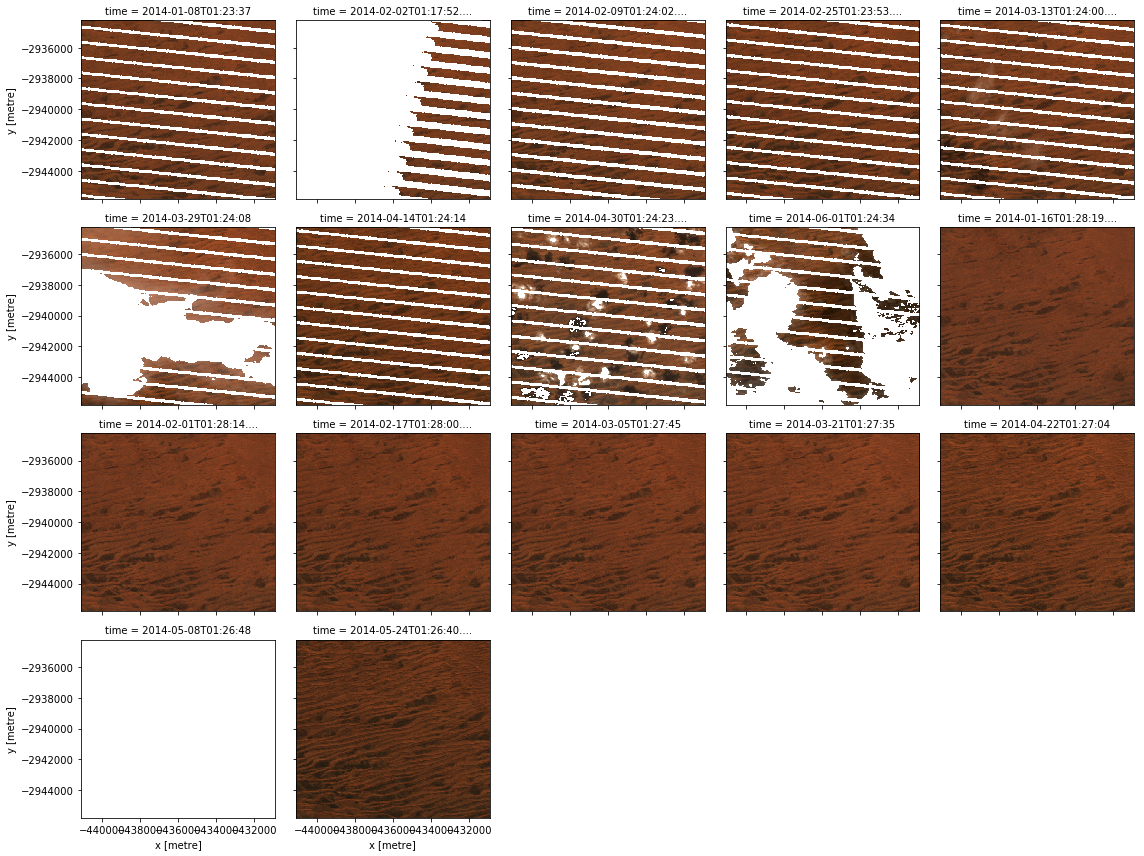

In [7]:
plot_with_colors(cloud_free_ls_nbar_data)

We can see here (cloud-free) Landsat-7 data (with those notorious stripes) interlaced with much more pleasant (cloud-free) Landsat-8 data.

The data flow here looks like:

![](cloud_free.svg "Dataflow")

## Grammar

Currently, there are four combinators for virtual products:

1. **_product_** - an existing datacube product
2. **_collate_** - stack observations from products with the same set of measurements
3. **_transform_** - on-the-fly computation on data being loaded
4. **_juxtapose_** - put measurements from different products side-by-side

We will go through them one by one.

## 1. **_product_**

Virtual products can be useful even for a simple existing product. The recipe looks like:

``{'product': <product_name>, **settings}``

where `settings` can include `dc.load` settings like
- `measurements`
- `output_crs`, `resolution`, `align`
- `resampling`
- `group_by`, `fuse_func`

For example, products with data in multiple CRS need output CRS and resolution to be specified.

In [8]:
# spatio-temporal query
query_s2 = {
    'time': ('2018-01-01', '2018-02-01'),
    'lat': (-27.0, -27.1),
    'lon': (127.5, 127.6)
}

dc.load(product='s2a_ard_granule', **query_s2)

ValueError: Product has no default CRS. Must specify 'output_crs' and 'resolution'

We can instead define a virtual product:

In [9]:
s2a_ard_albers = construct_from_yaml("""
    product: s2a_ard_granule
    output_crs: EPSG:3577
    resolution: [-20, 20]
    measurements: [nbart_blue, nbart_green]
    """)

s2a_ard_albers.load(dc, **query_s2)

<xarray.Dataset>
Dimensions:      (time: 1, x: 510, y: 578)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-20T01:37:11.026000
  * y            (y) float64 -2.934e+06 -2.934e+06 ... -2.946e+06 -2.946e+06
  * x            (x) float64 -4.411e+05 -4.411e+05 ... -4.309e+05 -4.309e+05
Data variables:
    nbart_blue   (time, y, x) int16 542 544 535 549 524 ... 477 448 495 456 481
    nbart_green  (time, y, x) int16 787 815 818 823 802 ... 662 635 770 664 694
Attributes:
    crs:      EPSG:3577

## 2. **_collate_**

A `collate` node concatenates observations from multiple sensors having the same set of measurements.

The grammar for the recipe looks like:

``{'collate': [<virtual_product_1>, <virtual_product_2>, ..., <virtual_product_N>]}``

Example:

In [10]:
ls_nbar_collate = construct_from_yaml("""
    collate:
      - product: ls7_nbar_albers
        measurements: [red, green, blue]
      - product: ls8_nbar_albers
        measurements: [red, green, blue]
    """)

ls_nbar_collate.load(dc, **query)

<xarray.Dataset>
Dimensions:  (time: 22, x: 408, y: 463)
Coordinates:
  * y        (y) float64 -2.934e+06 -2.934e+06 ... -2.946e+06 -2.946e+06
  * x        (x) float64 -4.411e+05 -4.411e+05 ... -4.309e+05 -4.309e+05
  * time     (time) datetime64[ns] 2014-01-01T01:17:26 ... 2014-06-01T01:24:34
Data variables:
    red      (time, y, x) int16 -999 -999 -999 -999 -999 ... 3020 3020 3078 3078
    green    (time, y, x) int16 -999 -999 -999 -999 -999 ... 2805 2772 2739 2805
    blue     (time, y, x) int16 -999 -999 -999 -999 -999 ... 2507 2478 2478 2507
Attributes:
    crs:      EPSG:3577

That is, observations from different sensors get interlaced:

![](collate.svg "collate")

## 3. **_transform_**

A `transform` node applies a data transformation to the loaded data.

The grammar for the recipe looks like:

``{'transform': <transformation_class>, 'input': <input_virtual_product>, **settings}``

where `settings` are keyword arguments to the initializer of the transformation class implementing the `Transformation` interface:

In [11]:
class Transformation:
    def compute(self, data):
        """ xarray.Dataset -> xarray.Dataset """
        
    def measurements(self, input_measurements):
        """ Dict[str, Measurement] -> Dict[str, Measurement] """

ODC has a (growing) set of built-in transformations:
- `make_mask`
- `apply_mask`
- `to_float`
- `rename`
- `select`

For example,

In [12]:
ls8_nbar_spanish = construct_from_yaml("""
    transform: rename
    input:
        product: ls8_nbar_albers
        measurements: [blue, green]
    measurement_names:
        blue: azul
        green: verde 
    """)

ls8_nbar_spanish.load(dc, **query)

<xarray.Dataset>
Dimensions:  (time: 8, x: 408, y: 463)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-16T01:28:19.500000 ... 2014-05-24T01:26:40.500000
  * y        (y) float64 -2.934e+06 -2.934e+06 ... -2.946e+06 -2.946e+06
  * x        (x) float64 -4.411e+05 -4.411e+05 ... -4.309e+05 -4.309e+05
Data variables:
    azul     (time, y, x) int16 546 542 551 546 532 523 ... 330 343 362 384 401
    verde    (time, y, x) int16 922 921 939 922 905 889 ... 583 606 632 683 717
Attributes:
    crs:      EPSG:3577

Users can also define custom transformations.

As an example, let's calculate the NDVI of Landsat-8 surface reflectance data.

This time instead of a `YAML` recipe, we use the combinators directly.

In [8]:
from datacube.virtual import Transformation, Measurement

In [9]:
class NDVI(Transformation):
    def compute(self, data):
        result = ((data.nir - data.red) / (data.nir + data.red))
        return result.to_dataset(name='NDVI')

    def measurements(self, input_measurements):
        return {'NDVI': Measurement(name='NDVI', dtype='float64', nodata=float('nan'), units='1')}

In [10]:
ndvi = construct(transform=NDVI, input=dict(product='ls8_nbar_albers', measurements=['red', 'nir']))

In [11]:
ndvi_data = ndvi.load(dc, **query)

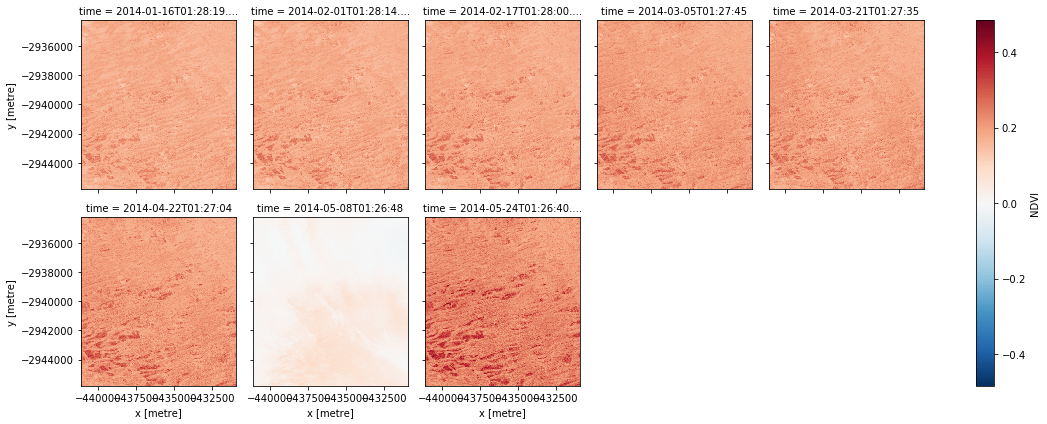

In [12]:
ndvi_data.NDVI.plot(col='time', col_wrap=5)

We can also easily verify that the odd-one-out observation just happened to be very cloudy.

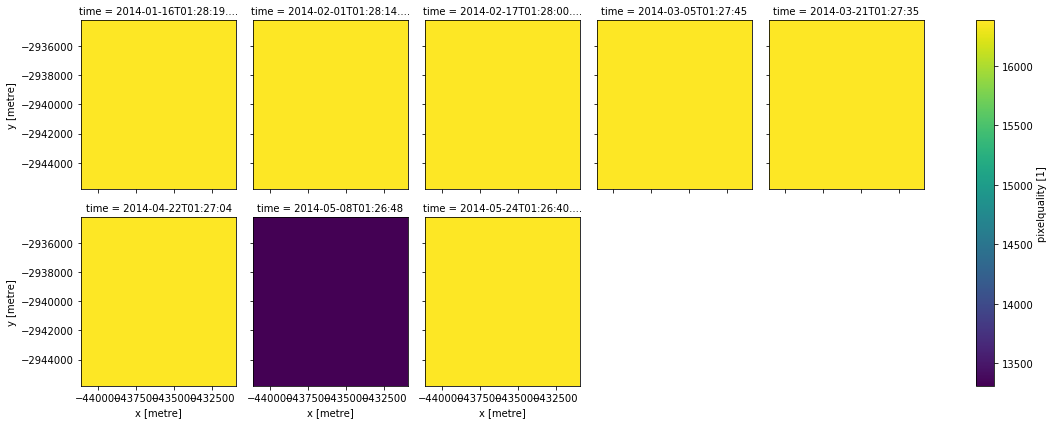

In [13]:
dc.load(product='ls8_pq_albers', **query).pixelquality.plot(col='time', col_wrap=5)

We can also achieve the same effect by using the `formula` transform

In [22]:
ndvi_formula = construct_from_yaml("""
    transform: formula
    output:
        NDVI:
            formula: ((nir - red) / (nir + red))
    input:
        product: ls8_nbar_albers
        measurements: [red, nir]
""")

In [26]:
ndvi_formula_data = ndvi_formula.load(dc, **query)

In [24]:
ndvi_formula_data

<xarray.Dataset>
Dimensions:  (time: 8, x: 408, y: 463)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-16T01:28:19.500000 ... 2014-05-24T01:26:40.500000
  * y        (y) float64 -2.934e+06 -2.934e+06 ... -2.946e+06 -2.946e+06
  * x        (x) float64 -4.411e+05 -4.411e+05 ... -4.309e+05 -4.309e+05
Data variables:
    NDVI     (time, y, x) float64 0.146 0.1398 0.1368 ... 0.2841 0.3182 0.2926
Attributes:
    crs:      EPSG:3577

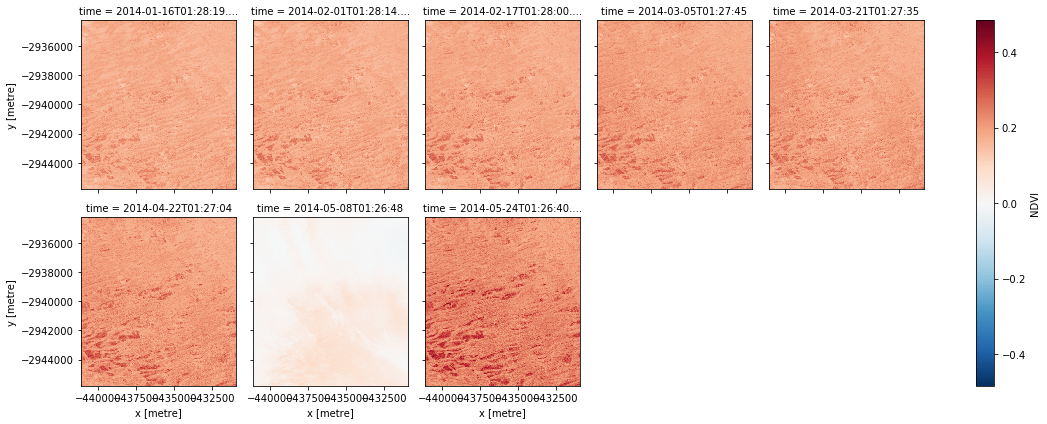

In [27]:
ndvi_formula_data.NDVI.plot(col='time', col_wrap=5)

## 4. **_juxtapose_**

 A `juxtapose` node merges disjoint sets of measurements from different products.


The grammar for the recipe is simple:

``{'juxtapose': [<virtual-product-1>, <virtual-product-2>, ..., <virtual-product-N>]}``

An example would be to juxtapose a pixel quality product to the imagery it was derived from:

In [19]:
ls8_nbar_pq = construct_from_yaml("""
    juxtapose:
      - product: ls8_nbar_albers
        measurements: [red, green, blue]
      - product: ls8_pq_albers
    """)

ls8_nbar_pq.load(dc, **query)

<xarray.Dataset>
Dimensions:       (time: 8, x: 408, y: 463)
Coordinates:
  * time          (time) datetime64[ns] 2014-01-16T01:28:19.500000 ... 2014-05-24T01:26:40.500000
  * y             (y) float64 -2.934e+06 -2.934e+06 ... -2.946e+06 -2.946e+06
  * x             (x) float64 -4.411e+05 -4.411e+05 ... -4.309e+05 -4.309e+05
Data variables:
    red           (time, y, x) int16 1690 1713 1777 1727 ... 944 1085 1082 1180
    green         (time, y, x) int16 922 921 939 922 905 ... 583 606 632 683 717
    blue          (time, y, x) int16 546 542 551 546 532 ... 330 343 362 384 401
    pixelquality  (time, y, x) int16 16383 16383 16383 ... 16383 16383 16383
Attributes:
    crs:      EPSG:3577

We have implemented the case where we want to keep the observations common to the two products.

That is, non-matching observations get dropped:

![](juxtapose.svg "juxtapose")